In [1]:
import os
import random
import numpy as np
import pandas as pd # Added for data handling in fit
import scipy.special
import scipy
from tqdm import tqdm
from sklearn.base import BaseEstimator, ClassifierMixin
# from sklearn.preprocessing import OneHotEncoder # Not needed for continuous mass attribute
from sklearn.utils import check_random_state
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset

# Imports
import numpy as np
import uproot
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit

# sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# Assume uproot, train_test_split, StandardScaler are imported elsewhere for your loaders
# import uproot
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler



Using device: cpu


In [2]:
# --- Plotting Functions (adapted) ---


# Re-define the plotting functions to accept PyTorch model outputs


# --- Helper Functions (from your provided code) ---

def exp_decay(x, a, b, c):
    return a * np.exp(-b * x) + c

def plot_confusion_matrix(y_true, y_pred, labels=["Background", "Signal"]):
    """
    Plot a normalized confusion matrix.
    """
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    fig, ax = plt.subplots(figsize=(6, 6))
    disp.plot(ax=ax, cmap=plt.cm.Blues, colorbar=False, values_format=".2f")
    ax.set_title("Normalized Confusion Matrix")
    plt.title("Normalized Confusion Matrix")
    plt.tight_layout()
    plt.show()

def plot_binned_background_shape(
    probs, # Pass probabilities directly now
    y_true, # Pass true labels
    mass_unscaled, # Pass the unscaled mass
    weight,
    bins=np.linspace(110, 160, 80),
    score_bins=[(0.00, 0.34), (0.34, 0.68), (0.68, 0.9), (0.9, 1.0)],
    colors=["blue", "orange", "green", "red"],
    higgs_mass=125
):
    """
    Plot binned dimuon mass distribution for background events,
    separated by classifier score bins, with exponential background fit.
    Now takes probabilities and unscaled mass directly.
    """

    # Ensure proper array types
    y_true = np.asarray(y_true)
    weight = np.asarray(weight)
    probs = np.asarray(probs)
    mass_unscaled = np.asarray(mass_unscaled)

    # Select background events
    mask_bkg = y_true == 0
    scores = probs[mask_bkg]
    masses = mass_unscaled[mask_bkg]
    weights_bkg = weight[mask_bkg]

    # Setup bins and labels
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    labels = [f"{low:.2f} ≤ Score < {high:.2f}" for (low, high) in score_bins]

    plt.figure(figsize=(9, 6))

    # Plot histograms by classifier score
    for (low, high), color, label in zip(score_bins, colors, labels):
        mask = (scores >= low) & (scores < high)
        hist, _ = np.histogram(masses[mask], bins=bins, weights=weights_bkg[mask], density=True)
        plt.step(bin_centers, hist, where="mid", color=color, label=label)

    # Full background shape and fit
    hist_all, _ = np.histogram(masses, bins=bins, weights=weights_bkg, density=True)
    try:
        # Filter out zeros from hist_all for fitting if necessary
        valid_indices = hist_all > 0
        popt, _ = curve_fit(exp_decay, bin_centers[valid_indices], hist_all[valid_indices], p0=(1, 0.1, 0))
        smoothed = exp_decay(bin_centers, *popt)
        plt.plot(bin_centers, smoothed, 'k--', label="Fitted Background Shape")
    except RuntimeError:
        print("⚠️ Background fit failed. Skipping fit curve.")
    except ValueError as e:
         print(f"⚠️ Background fit failed due to ValueError: {e}. Skipping fit curve.")

    # Higgs mass line
    plt.axvline(higgs_mass, color="gray", linestyle=":", label="Higgs Mass")

    # Final styling
    plt.xlabel(r"$M_{\mu\mu}$ [GeV]")
    plt.ylabel("Fraction of events")
    plt.title("Background Shape by Classifier Score")
    plt.legend(title="Score Bins")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [38]:
def load_data(file_path, columns, tree_name="tree_Hmumu"):
    """
    Load data from a ROOT file using uproot.
    """
    try:
        tree = uproot.open(file_path)[tree_name]
        df = tree.arrays(columns, library="pd")
        # Consider if sampling is always desired or should be a parameter
        df_sampled = df.sample(frac=0.01, random_state=42)  # Added random_state for reproducibility
        # For now, using the full dataset as frac=0.1 might be too small for robust training
        return df_sampled
    except Exception as e:
        print(f"Error loading data from {file_path}: {e}")
        print("Please ensure the ROOT files are in the correct path and uproot is installed.")
        # Return empty DataFrame or raise to stop execution
        return pd.DataFrame()


def prepare_data(background_df, signal_df, mass_column="Muons_Minv_MuMu_Fsr", shuffle=True):
    """
    Combine background and signal datasets, shuffle, and split into features, labels, weights, and mass.
    """
    if background_df.empty or signal_df.empty:
        print("One or both dataframes are empty. Cannot prepare data.")
        # Return empty tuples to signal failure
        return pd.DataFrame(), pd.Series(dtype="float64"), pd.Series(dtype="float64"), np.array([])

    df = pd.concat([background_df, signal_df], ignore_index=True)

    if shuffle:
        df = df.sample(frac=1, random_state=42).reset_index(drop=True)

    x = df.drop(["Binary_Target", "weight", mass_column], axis=1)
    y = df["Binary_Target"]
    mass = df[mass_column]
    weight = df["weight"].to_numpy()

    y = y.to_numpy()
    mass = mass.to_numpy()

    return x, y, mass, weight


def split_and_scale(X, y, mass, weight, test_size=0.2):
    """
    Split the dataset and apply standard scaling to features and mass separately.
    """
    if X.empty:
        print("Input feature DataFrame X is empty in split_and_scale. Cannot proceed.")
        # Return dummy values or raise an error
        return (None,) * 10 + ([],)  # Match number of return values

    X_train, X_test, y_train, y_test, mass_train, mass_test, weight_train, weight_test = (
        train_test_split(X, y, mass, weight, test_size=test_size, random_state=42, stratify=y)
    )

    feature_scaler = StandardScaler()
    X_train_scaled = feature_scaler.fit_transform(X_train)
    X_test_scaled = feature_scaler.transform(X_test)

    mass_scaler = StandardScaler()
    mass_train_scaled = mass_scaler.fit_transform(mass_train.reshape(-1, 1)).flatten()
    mass_test_scaled = mass_scaler.transform(mass_test.reshape(-1, 1)).flatten()

    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)
    mass_train_tensor = torch.tensor(mass_train_scaled, dtype=torch.float32).unsqueeze(1)
    mass_test_tensor = torch.tensor(mass_test_scaled, dtype=torch.float32).unsqueeze(1)
    weight_train_tensor = torch.tensor(weight_train, dtype=torch.float32)
    weight_test_tensor = torch.tensor(weight_test, dtype=torch.float32)

    return (
        X_train_tensor,
        X_test_tensor,
        y_train_tensor,
        y_test_tensor,
        mass_train_tensor,
        mass_test_tensor,
        weight_train_tensor,
        weight_test_tensor,
        feature_scaler,
        mass_scaler,
        X.columns.tolist(),
    )  # Return feature names


In [82]:

class classifier_model(nn.Module):
    def __init__(self,feature,Hneuron1,output,dropout,seed1,seed2):
        super(classifier_model, self).__init__()
        self.feature = feature
        self.hN1 = Hneuron1
        self.output = output # Should be 1 for binary classification with BCEWithLogitsLoss
        self.dropout = dropout
        # seed1, seed2 not explicitly used in PyTorch layer seeding here,
        # global torch.manual_seed is usually preferred.
        # self.seed1 = seed1
        # self.seed2 = seed2
        self.FC1 = nn.Linear(self.feature,128)
        # self.FC1 = nn.Linear(self.feature,self.hN1)
        self.FC2 = nn.Linear(128,self.hN1)
        self.FC3 = nn.Linear(self.hN1,self.output)
        self.sigmoid = torch.sigmoid
        self.relu = F.relu
        self.Dropout = nn.Dropout(p=0)

    def forward(self, x_input):
        # Pass input through first fully connected layer, ReLU, and Dropout
        hidden_representation = self.Dropout(self.relu(self.FC2(self.relu(self.FC1(x_input)))))
        # hidden_representation = self.Dropout(self.relu(self.FC1(x_input)))
        # Get logits from the second fully connected layer
        x_logits = self.FC3(hidden_representation)
        # Apply sigmoid to logits to get prediction probabilities (usually for inference/thresholding)
        # For training with BCEWithLogitsLoss, raw logits are typically used.
        x_pred_proba = self.sigmoid(x_logits)
        return hidden_representation, x_pred_proba, x_logits

class adversary_model(nn.Module):
    def __init__(self, hidden_layer_size, seed3, adv_hidden_neurons=None):
        super(adversary_model, self).__init__()
        # seed3 not explicitly used here, global torch.manual_seed is usually preferred.
        # self.seed3 = seed3

        # Define the adversary's architecture
        # It takes the classifier's hidden layer output and predicts a single continuous value (mass)
        if adv_hidden_neurons is None:
            adv_hidden_neurons = hidden_layer_size // 2
        
        self.FC1 = nn.Linear(hidden_layer_size, 128)
        self.relu = F.relu
        self.dropout = nn.Dropout(0) # Example dropout
        self.FC2 = nn.Linear(128, adv_hidden_neurons)
        self.FC3 = nn.Linear(adv_hidden_neurons, 5) # Output dimension is 1 (for mass regression)

    def forward(self, hidden_representation):
        x = self.dropout(self.relu(self.FC1(hidden_representation)))
        x = self.dropout(self.relu(self.FC2(x)))
        pred_mass = self.FC3(x) # Raw output for regression
        return pred_mass


class AdversarialDebiasing(BaseEstimator, ClassifierMixin):
    def __init__(self, prot_attr=None, # Name of the mass column in the y DataFrame
                 adversary_loss_weight=0.1, num_epochs=50, batch_size=256,
                 classifier_num_hidden_units=200, # H1 for classifier
                 adversary_num_hidden_units=None, # Hidden units for adversary MLP
                 debias=True, verbose=False,
                 random_state=None):
        r"""
        Args:
            prot_attr (str): Name of the column in the 'y' DataFrame passed to 'fit'
                             that contains the continuous variable for the adversary to predict (e.g., muon mass).
            adversary_loss_weight (float): Lambda coefficient for the adversarial loss term in the classifier's update.
            classifier_num_hidden_units (int): Number of hidden units in the classifier's main hidden layer.
            adversary_num_hidden_units (int, optional): Number of hidden units in the adversary's hidden layer.
                                                      Defaults to classifier_num_hidden_units // 2.
            (Other parameters as in original)
        """

        self.prot_attr = prot_attr
        self.adversary_loss_weight = adversary_loss_weight
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.classifier_num_hidden_units = classifier_num_hidden_units
        self.adversary_num_hidden_units = adversary_num_hidden_units if adversary_num_hidden_units is not None else classifier_num_hidden_units // 2
        self.debias = debias
        self.verbose = verbose # verbose not explicitly used in provided snippet, but good to have
        self.random_state = random_state
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.clf_model = None
        self.adv_model = None
        self.classes_ = None # Will be set in fit for classifier's target

    def set_all_seed(self, seed):
        os.environ["PL_GLOBAL_SEED"] = str(seed)
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    def init_parameters(self, net):
        for m in net.modules():
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight.data) # Changed to Xavier
                # torch.nn.init.normal_(m.weight.data, mean=0, std=0.01) # Alternative
                nn.init.constant_(m.bias.data, 0)

    def fit(self, X, y):
        """Train the classifier and adversary.

        Args:
            X (pandas.DataFrame or numpy.ndarray): Training samples (features).
            y (pandas.DataFrame): DataFrame containing the target variable for classification
                                 and the continuous 'protected' attribute (e.g., mass)
                                 for the adversary. It must contain the column specified
                                 in `self.prot_attr`.
        Returns:
            self
        """
        if not isinstance(X, pd.DataFrame) and not isinstance(X, np.ndarray):
            raise ValueError("X must be a pandas DataFrame or numpy array.")
        if not isinstance(y, pd.DataFrame):
            raise ValueError("y must be a pandas DataFrame.")
        if self.prot_attr is None or self.prot_attr not in y.columns:
            raise ValueError(f"Protected attribute '{self.prot_attr}' not found in y DataFrame columns: {y.columns}")

        if isinstance(X, pd.DataFrame):
            X_tensor = torch.tensor(X.values.astype(np.float32)).to(self.device)
        else: # numpy array
            X_tensor = torch.tensor(X.astype(np.float32)).to(self.device)

        num_train_samples, n_features = X_tensor.shape

        # Protected attribute (continuous mass for the adversary)
        mass_values = y[self.prot_attr]
        mass_tensor = torch.tensor(mass_values.values.astype(np.float32).reshape(-1, 1)).to(self.device)

        mass_values_for_binning = y[self.prot_attr].values.astype(np.float32) # Use unscaled or scaled as preferred

        # Define your mass bins (example for unscaled mass, adjust as needed)
        # Bins: (-inf, 110), [110, 140), [140, inf) -> labels 0, 1, 2
        # This focuses on a signal region [110, 140)
        bins = [-np.inf, -1, -0.5, 0.5, 1, np.inf]
        self.num_mass_bins_ = len(bins) - 1 # Store for adversary output layer size

        # Convert continuous mass to bin labels (integers)
        mass_bin_labels = pd.cut(mass_values_for_binning, bins=bins, labels=False, right=False)
        mass_bin_labels_tensor = torch.tensor(mass_bin_labels, dtype=torch.long).to(self.device) # CrossEntropyLoss expects long

        # Classifier labels
        # Assuming the target column is the one in 'y' that is NOT 'self.prot_attr'
        # If 'y' could have more than two columns, this logic might need adjustment.
        target_column_names = [col for col in y.columns if col != self.prot_attr]
        if not target_column_names:
            raise ValueError("No target column found in y DataFrame after excluding prot_attr.")
        if len(target_column_names) > 1:
            print(f"Warning: Multiple potential target columns found: {target_column_names}. Using '{target_column_names[0]}'.")
        target_column_name = target_column_names[0]

        y_clf_values = y[target_column_name]
        self.classes_ = np.unique(y_clf_values) # Store unique class labels (e.g., [0, 1])
        
        y_clf_tensor = torch.tensor(y_clf_values.values.astype(np.float32).reshape(-1, 1)).to(self.device)

        n_clf_outputs = 1 # For binary classification with BCEWithLogitsLoss

        if self.random_state is not None:
            self.set_all_seed(self.random_state)
        else:
            self.set_all_seed(42) # Default seed

        # PyTorch seeds are set by set_all_seed. s1,s2,s3 for TF compatibility not directly used.
        # ii32 = np.iinfo(np.int32)
        # rng = check_random_state(self.random_state) # Already used in set_all_seed
        # self.s1, self.s2, self.s3 = rng.randint(ii32.min, ii32.max, size=3)


        starter_learning_rate = 0.001
        self.clf_model = classifier_model(feature=n_features,
                                          Hneuron1=self.classifier_num_hidden_units,
                                          output=n_clf_outputs, # Output 1 logit for binary
                                          dropout=0.1, # Example dropout
                                          seed1=None, seed2=None).to(self.device) # Seeds handled globally
        self.init_parameters(self.clf_model)
        classifier_opt = torch.optim.Adam(self.clf_model.parameters(), lr=starter_learning_rate, weight_decay=1e-5)

        # DataLoader
        dataset = TensorDataset(X_tensor, y_clf_tensor, mass_bin_labels_tensor)
        dataBatch = DataLoader(dataset, batch_size=self.batch_size, shuffle=True, drop_last=False)

        lossCLF = F.binary_cross_entropy_with_logits # Classifier loss
        lossADV = F.cross_entropy # Adversary loss (predicting continuous mass)

        # --- Pre-training Phase ---
        # 1. Pre-train Classifier
        print("--- Starting Classifier Pre-training ---")
        pretrain_clf_epochs = self.num_epochs // 4 if self.debias else self.num_epochs # More if no debias
        with tqdm(range(pretrain_clf_epochs), desc="Classifier PreTraining") as epochs:
            for epoch in epochs:
                self.clf_model.train()
                epoch_loss_clf = 0
                epoch_acc_clf = 0
                for X_b, y_clf_b, _ in dataBatch: # mass_b not used here
                    classifier_opt.zero_grad()
                    _, pred_labels_proba, pred_logits = self.clf_model(X_b)
                    loss = lossCLF(pred_logits, y_clf_b, reduction='mean')
                    loss.backward()
                    classifier_opt.step()

                    epoch_loss_clf += loss.item() * X_b.size(0)
                    acc_b = ((pred_labels_proba > 0.5).float() == y_clf_b).float().sum().item()
                    epoch_acc_clf += acc_b
                
                avg_loss = epoch_loss_clf / num_train_samples
                avg_acc = epoch_acc_clf / num_train_samples
                epochs.set_postfix(loss=avg_loss, acc=avg_acc)

        if self.debias:
            self.adv_model = adversary_model(hidden_layer_size=self.classifier_num_hidden_units,
                                             adv_hidden_neurons=self.adversary_num_hidden_units,
                                             seed3=None).to(self.device) # Seed handled globally
            self.init_parameters(self.adv_model)
            adversary_opt = torch.optim.Adam(self.adv_model.parameters(), lr=starter_learning_rate, weight_decay=1e-5)

            # 2. Pre-train Adversary (to predict mass from classifier's initial hidden representations)
            print("--- Starting Adversary Pre-training ---")
            pretrain_adv_epochs = self.num_epochs // 10 # Fewer epochs typically
            with tqdm(range(pretrain_adv_epochs), desc="Adversary PreTraining (Predict Mass)") as epochs:
                for epoch in epochs:
                    self.adv_model.train()
                    self.clf_model.eval() # Classifier is fixed during adversary pre-training
                    epoch_loss_adv = 0
                    for X_b, _, mass_b in dataBatch: # y_clf_b not used
                        adversary_opt.zero_grad()
                        with torch.no_grad(): # Get hidden_rep without tracking gradients back to classifier
                            hidden_rep_detached, _, _ = self.clf_model(X_b)
                        pred_mass_by_adv = self.adv_model(hidden_rep_detached)
                        loss = lossADV(pred_mass_by_adv, mass_b, reduction='mean')
                        loss.backward()
                        adversary_opt.step()
                        epoch_loss_adv += loss.item() * X_b.size(0)
                    avg_loss = epoch_loss_adv / num_train_samples
                    epochs.set_postfix(mse_loss=avg_loss)
            
            # --- Adversarial Debiasing Training ---
            print('--- Starting Adversarial Debiasing Mitigation ---')
            main_epochs = self.num_epochs
            with tqdm(range(main_epochs), desc="Adversarial Debiasing") as epochs:
                for epoch in epochs:
                    self.clf_model.train()
                    self.adv_model.train() # Both models are in training mode
                    
                    epoch_loss_clf_task_total = 0
                    epoch_loss_adv_influence_total = 0
                    epoch_loss_adv_train_total = 0
                    epoch_acc_clf_total = 0

                    for X_b, y_clf_b, mass_b in dataBatch:
                        # --- Train Classifier (to minimize task loss and maximize adversary's mass prediction error) ---
                        classifier_opt.zero_grad()

                        # Part A: Gradient from classification loss
                        # Forward pass through classifier (tracks gradients for W_clf)
                        hidden_rep, pred_labels_proba, pred_logits_clf = self.clf_model(X_b)
                        loss_clf_task = lossCLF(pred_logits_clf, y_clf_b, reduction='mean')
                        
                        # Calculate dL_clf / dW_clf
                        # Need to retain graph because hidden_rep will be used again for adversary's influence calculation
                        loss_clf_task.backward(retain_graph=True)
                        clf_grad_from_task = [par.grad.clone().detach() if par.grad is not None \
                                              else torch.zeros_like(par) for par in self.clf_model.parameters()]
                        classifier_opt.zero_grad() # Zero grads on classifier params before next grad calculation

                        # Part B: Gradient from adversary's loss (how W_clf affects L_adv for mass)
                        # hidden_rep is from self.clf_model(X_b) and is differentiable w.r.t W_clf
                        pred_mass_for_clf_update = self.adv_model(hidden_rep) # hidden_rep is NOT detached
                        loss_adv_influence_on_clf = lossADV(pred_mass_for_clf_update, mass_b, reduction='mean') # MSE

                        # Calculate dL_adv_influence / dW_clf.
                        # This backward pass also computes and stores dL_adv_influence / dW_adv in adv_model.parameters.grad.
                        # We will use these dW_adv grads later for the adversary's own update.
                        loss_adv_influence_on_clf.backward()
                        
                        adv_grad_wrt_clf = []
                        for par in self.clf_model.parameters():
                            if par.grad is not None:
                                adv_grad_wrt_clf.append(par.grad.clone().detach())
                            else: # Should ideally not happen if param contributes to hidden_rep
                                adv_grad_wrt_clf.append(torch.zeros_like(par))
                        
                        # Store adversary's own gradients (dL_adv_influence / dW_adv) from the backward pass above
                        adv_own_grads_for_update = []
                        for par in self.adv_model.parameters():
                            if par.grad is not None:
                                adv_own_grads_for_update.append(par.grad.clone().detach())
                            else: # Should not happen if param is used
                                adv_own_grads_for_update.append(torch.zeros_like(par))
                        
                        # Zero out gradients on both models after collecting them
                        classifier_opt.zero_grad()
                        adversary_opt.zero_grad()

                        # Combine gradients for classifier update using the projection method
                        with torch.no_grad(): # Manually set gradients for classifier_opt.step()
                            for i, par in enumerate(self.clf_model.parameters()):
                                cg = clf_grad_from_task[i] # Gradient for classification task
                                ag = adv_grad_wrt_clf[i]  # Gradient for how W_clf affects adversary's mass prediction

                                # par.grad = cg - self.adversary_loss_weight * ag # Simplest form (gradient reversal)
                                # Using the projection method from your original code:
                                if torch.norm(ag) > 1e-9: 
                                    unit_adversary_grad = ag / (torch.norm(ag) + torch.finfo(float).tiny)
                                    proj = torch.sum(unit_adversary_grad * cg) # Inner product
                                    # Update rule: grad_task - projection_of_grad_task_onto_grad_adv - scaled_grad_adv
                                    # This aims to make progress on task, remove components helping adversary,
                                    # and actively move against adversary.
                                    # print(proj * unit_adversary_grad, self.adversary_loss_weight)
                                    # par.grad = cg -  (1-np.exp(-proj * unit_adversary_grad)) - (1-np.exp(-self.adversary_loss_weight)) * ag
                                    par.grad = cg -  proj * unit_adversary_grad - self.adversary_loss_weight * ag
                                else: # If adversary gradient is zero, no penalty/projection needed
                                    par.grad = cg
                        torch.nn.utils.clip_grad_norm_(self.clf_model.parameters(), max_norm=3.0) # Clip classifier grads
                        classifier_opt.step() # Update classifier weights

                        # --- Train Adversary (to minimize its own mass prediction error) ---
                        # Use the gradients dL_adv_influence / dW_adv collected earlier
                        with torch.no_grad():
                             for i, par in enumerate(self.adv_model.parameters()):
                                par.grad = adv_own_grads_for_update[i]
                        torch.nn.utils.clip_grad_norm_(self.adv_model.parameters(), max_norm=3.0) # Clip adversary grads
                        adversary_opt.step() # Update adversary weights

                        # Accumulate losses and accuracy for epoch summary
                        epoch_loss_clf_task_total += loss_clf_task.item() * X_b.size(0)
                        epoch_loss_adv_influence_total += loss_adv_influence_on_clf.item() * X_b.size(0)
                        # For a consistent adversary training loss metric, we can re-evaluate it with detached hidden_rep
                        with torch.no_grad():
                            self.clf_model.eval() # Temp switch to eval for clean hidden_rep
                            h_rep_detached_metric, _, _ = self.clf_model(X_b)
                            self.clf_model.train() # Switch back
                            adv_pred_metric = self.adv_model(h_rep_detached_metric)
                            loss_adv_train_metric = lossADV(adv_pred_metric, mass_b)
                            epoch_loss_adv_train_total += loss_adv_train_metric.item() * X_b.size(0)

                        acc_clf_batch = ((pred_labels_proba > 0.5).float() == y_clf_b).float().sum().item()
                        epoch_acc_clf_total += acc_clf_batch
                    
                    avg_loss_clf = epoch_loss_clf_task_total / num_train_samples
                    avg_loss_adv_infl = epoch_loss_adv_influence_total / num_train_samples
                    avg_loss_adv_train = epoch_loss_adv_train_total / num_train_samples
                    avg_acc_clf = epoch_acc_clf_total / num_train_samples
                    epochs.set_postfix(clf_loss=avg_loss_clf, adv_infl_loss=avg_loss_adv_infl, 
                                       adv_train_mse=avg_loss_adv_train, clf_acc=avg_acc_clf)
        else: # Not debiasing, standard classifier training (already pre-trained)
             print("Debiasing is turned off. Classifier was already pre-trained.")
             # If pre-training was shorter for debias=True, you might want full training here.
             # For now, this assumes pre-training was sufficient.

        return self

    def decision_function(self, X):
        if self.clf_model is None:
            raise RuntimeError("Model has not been trained yet. Call fit() first.")
        if isinstance(X, pd.DataFrame):
            X_np = X.values.astype(np.float32)
        elif isinstance(X, np.ndarray):
            X_np = X.astype(np.float32)
        else:
            raise ValueError("Input X must be a pandas DataFrame or numpy array.")

        X_tensor = torch.tensor(X_np).to(self.device)
        
        self.clf_model.eval()
        pred_probas_list = []
        with torch.no_grad():
            dataLoader = DataLoader(TensorDataset(X_tensor), batch_size=self.batch_size, shuffle=False)
            for (X_b,) in dataLoader: # X_b is already a tuple from TensorDataset
                _, pred_probas, _ = self.clf_model(X_b) # We need probabilities for decision scores
                pred_probas_list.append(pred_probas.cpu().numpy())
        
        scores = np.concatenate(pred_probas_list, axis=0)
        # For binary classification, decision_function often returns the probability of the positive class
        return scores.ravel() if scores.shape[1] == 1 else scores


    def predict_proba(self, X):
        if self.clf_model is None:
            raise RuntimeError("Model has not been trained yet. Call fit() first.")
        
        # Get the probability of the positive class (class 1)
        positive_class_proba = self.decision_function(X)
        
        # Reshape to (n_samples, 1) if it's flat
        if positive_class_proba.ndim == 1:
            positive_class_proba = positive_class_proba.reshape(-1, 1)
            
        # Probability of the negative class (class 0) is 1 - P(class 1)
        negative_class_proba = 1.0 - positive_class_proba
        
        # Concatenate to form (n_samples, 2) array [P(class 0), P(class 1)]
        # Order should match self.classes_ (e.g., if self.classes_ is [0, 1])
        # Assuming self.classes_ are sorted, typically [0, 1]
        return np.hstack([negative_class_proba, positive_class_proba])

    def predict(self, X):
        if self.clf_model is None:
            raise RuntimeError("Model has not been trained yet. Call fit() first.")
        if self.classes_ is None :
            raise RuntimeError("Model classes_ not set. Fit was not properly completed.")

        # Get probabilities P(class 1)
        scores = self.decision_function(X) # This returns P(class 1)
        
        # Threshold at 0.5
        # If score > 0.5, predict 1, else 0 (assuming binary)
        binary_predictions = (scores > 0.5).astype(int)
        
        # Map to original class labels stored in self.classes_
        # E.g., if self.classes_ = [0, 1], then indices [0, 1] map directly.
        # If self.classes_ = [-1, 1], then indices [0, 1] would map to -1 and 1.
        # For binary 0/1, this is straightforward.
        return self.classes_[binary_predictions]

In [95]:
# --- 1. Load and Prepare Data ---
# Configuration
COLUMNS = [
    "Jets_PT_Lead",
    "Jets_PT_Sub",
    "Jets_Phi_Lead",
    "Jets_Phi_Sub",
    "Jets_E_Lead",
    "Jets_E_Sub",
    "Jets_Eta_Lead",
    "Jets_Eta_Sub",
    "Muons_PT_Lead",
    "Muons_PT_Sub",
    "Muons_Phi_Lead",
    "Muons_Phi_Sub",
    "Muons_Eta_Lead",
    "Muons_Eta_Sub",
    "Muons_Minv_MuMu_Fsr",  # Mass column
    "weight",
    "Binary_Target",
]
MASS_COLUMN_NAME = "Muons_Minv_MuMu_Fsr"
# Adjust these paths to your actual file locations
BACKGROUND_FILE = "./../Fairness data/Background.root"  # Example path
SIGNAL_FILE = "./../Fairness data/Signal.root"  # Example path

background_df = load_data(BACKGROUND_FILE, COLUMNS)
signal_df = load_data(SIGNAL_FILE, COLUMNS)
X_all_df, y_all_np, mass_all_np, weights_all_np = prepare_data(background_df, signal_df, mass_column=MASS_COLUMN_NAME)

# --- 2. Split and Scale ---
# This function needs to return pandas DataFrames for X_train/X_test to match class expectation,
# or you convert tensors back. For simplicity, let's assume you adapt its output or the class input.
# For now, let's assume you get NumPy arrays from split_and_scale for X and scaled mass.

(X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor,
 mass_train_tensor, mass_test_tensor, _, _, _, mass_scaler, feature_names) = split_and_scale(X_all_df, y_all_np, mass_all_np, weights_all_np)

# Convert relevant tensors back to NumPy for creating the DataFrames expected by AdversarialDebiasing.fit
X_train_np = X_train_tensor.cpu().numpy()
y_train_np = y_train_tensor.cpu().numpy().flatten() # Ensure y_train is 1D for DataFrame
mass_train_scaled_np = mass_train_tensor.cpu().numpy().flatten() # Ensure mass_train is 1D

X_test_np = X_test_tensor.cpu().numpy()
y_test_np = y_test_tensor.cpu().numpy().flatten()
mass_test_scaled_np = mass_test_tensor.cpu().numpy().flatten()


# --- 3. Create DataFrames for fitting ---
# Important: The column name for mass ('muon_mass_scaled' here) must match `prot_attr`.
# The other column ('binary_target') will be used as the classification target.

train_features_df = pd.DataFrame(X_train_np, columns=feature_names)
train_labels_and_mass_df = pd.DataFrame({
    'binary_target': y_train_np,
    'muon_mass_scaled': mass_train_scaled_np # This is the scaled mass
})

test_features_df = pd.DataFrame(X_test_np, columns=feature_names)
# For evaluation, you might not need the mass in the y_df for predict, but it's good practice
test_labels_and_mass_df = pd.DataFrame({
    'binary_target': y_test_np,
    'muon_mass_scaled': mass_test_scaled_np
})


# --- 4. Initialize and Train Model ---
adv_debias_model = AdversarialDebiasing(
    prot_attr='muon_mass_scaled',  # This MUST match the column name used above
    adversary_loss_weight=100, # Tune this hyperparameter
    num_epochs=50,
    batch_size=128,
    classifier_num_hidden_units=128,
    adversary_num_hidden_units=64,
    debias=True,
    random_state=42
)

adv_debias_model.fit(train_features_df, train_labels_and_mass_df)

# --- 5. Predict and Evaluate ---
predictions = adv_debias_model.predict(test_features_df)
probabilities = adv_debias_model.predict_proba(test_features_df)

# ... then your evaluation metrics ...
# Remember to evaluate not only classification accuracy but also the bias regarding muon mass.
# For instance, check classifier performance in bins of true muon mass,
# or try to predict mass from classifier outputs/hidden states on test data.

--- Starting Classifier Pre-training ---


Classifier PreTraining: 100%|██████████| 12/12 [00:15<00:00,  1.33s/it, acc=0.828, loss=0.392]


--- Starting Adversary Pre-training ---


Adversary PreTraining (Predict Mass): 100%|██████████| 5/5 [00:06<00:00,  1.24s/it, mse_loss=0.0636]


--- Starting Adversarial Debiasing Mitigation ---


Adversarial Debiasing: 100%|██████████| 50/50 [02:06<00:00,  2.54s/it, adv_infl_loss=0.436, adv_train_mse=0.436, clf_acc=0.767, clf_loss=0.46] 



--- Plotting Confusion Matrix ---


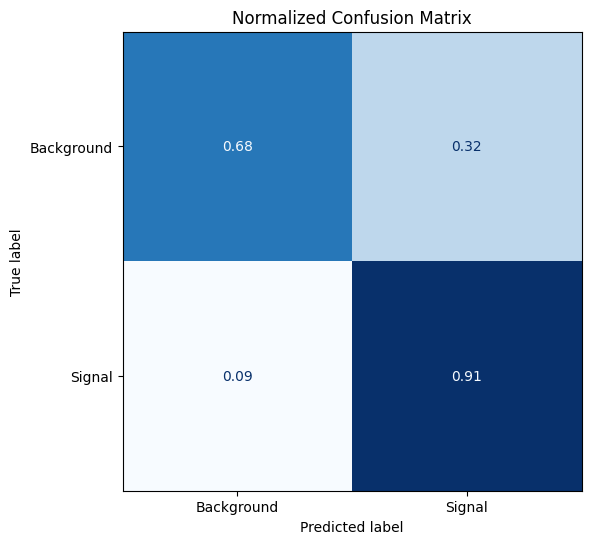


--- Plotting Binned Background Shape ---


C:\Users\lode6\AppData\Local\Temp\ipykernel_22892\3488413233.py:10: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c
C:\Users\lode6\AppData\Local\Temp\ipykernel_22892\3488413233.py:10: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c


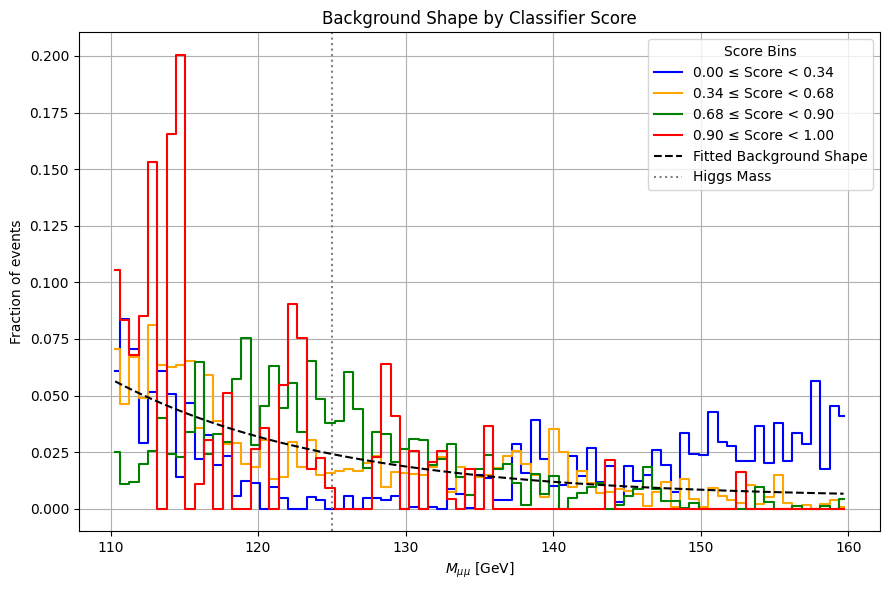

✅ Plotting complete.


In [96]:
_, _, _, _, mass_train_unscaled_np, mass_test_unscaled_np, _, weights_test_np_from_split = train_test_split(
    X_all_df, # Features (dummy here, just for consistent splitting)
    y_all_np, # Target for stratification
    mass_all_np, # Actual mass values to split
    weights_all_np, # Actual weight values to split
    test_size=0.2, # Make sure this matches the test_size in split_and_scale
    random_state=42, # Must match!
    stratify=y_all_np # Must match!
)
# Note: your `split_and_scale` returns `weight_test_tensor`.
# If it's already the correct split of original weights, you can use:
# weights_test_np = weight_test_tensor.cpu().numpy().flatten()
# And for unscaled mass, your `split_and_scale` should ideally return it.
# If mass_test_tensor is the SCALED mass, we need the unscaled version.
# `mass_test_unscaled_np` from the re-split above is what we need.


# 1. Plot Confusion Matrix
print("\n--- Plotting Confusion Matrix ---")
plot_confusion_matrix(y_test_np, predictions)

# 2. Plot Binned Background Shape
print("\n--- Plotting Binned Background Shape ---")
# `probabilities` is an array of shape (n_samples, 2), where column 0 is P(class 0) and column 1 is P(class 1).
# The `plot_binned_background_shape` expects `probs` to be the probability of the positive class (signal).
positive_class_probabilities = probabilities[:, 1]

plot_binned_background_shape(
    probs=positive_class_probabilities,
    y_true=y_test_np,
    mass_unscaled=mass_test_unscaled_np, # Use the unscaled mass for the test set
    weight=weights_test_np_from_split, # Use the weights for the test set
    # You can adjust bins, score_bins, etc. as needed
)

print("✅ Plotting complete.")

In [7]:
MODEL_SAVE_PATH = "adversarial_model/great_fairness_bad_perf"
# Uncomment to save trained classifier
torch.save(adv_debias_model.clf_model.state_dict(), MODEL_SAVE_PATH+"/classifier.pth")
print(f"Classifier model saved to {MODEL_SAVE_PATH}")
if adv_debias_model.adv_model is not None:
    torch.save(adv_debias_model.adv_model.state_dict(), MODEL_SAVE_PATH+"/adversarial.pth")
    print(f"Adversary model saved to {MODEL_SAVE_PATH}")

# --- Loading and Evaluating Models ---
# print("\n--- Loading and Evaluating Saved Models ---")
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# # Parameters needed to re-initialize models (should match training)
# # These can be fetched from the adv_debias_model instance if it's still in scope,
# # or saved/known from configuration.
# n_features_loaded = adv_debias_model.n_features_ # Or test_features_df.shape[1]
# clf_hidden_units_loaded = adv_debias_model.classifier_num_hidden_units
# clf_output_loaded = 1 # For binary classification
# clf_dropout_loaded = adv_debias_model.classifier_dropout

# adv_input_size_loaded = adv_debias_model.classifier_num_hidden_units # Adversary takes classifier's hidden output
# adv_hidden_units_loaded = adv_debias_model.adversary_num_hidden_units

# # Instantiate new models
# loaded_classifier = classifier_model(
#     feature=n_features_loaded,
#     Hneuron1=clf_hidden_units_loaded,
#     output=clf_output_loaded,
#     dropout=clf_dropout_loaded,
#     seed1=None, seed2=None # Seeds are for weight init, not structure
# ).to(device)

# loaded_classifier.load_state_dict(torch.load(clf_model_path, map_location=device))
# loaded_classifier.eval() # Set to evaluation mode
# print("Classifier model loaded successfully.")

# if os.path.exists(adv_model_path) and adv_debias_model.debias: # Only load if adversary was trained and saved
#     loaded_adversary = adversary_model(
#         hidden_layer_size=adv_input_size_loaded,
#         adv_hidden_neurons=adv_hidden_units_loaded,
#         seed3=None
#     ).to(device)
#     loaded_adversary.load_state_dict(torch.load(adv_model_path, map_location=device))
#     loaded_adversary.eval()
#     print("Adversary model loaded successfully.")
# else:
#     loaded_adversary = None
#     print("Adversary model not loaded (either not saved or debias=False).")

# # To use the evaluation functions from AdversarialDebiasing conveniently,
# # we can create a new instance and set its trained model and necessary attributes.
# evaluation_wrapper = AdversarialDebiasing(
#     prot_attr=adv_debias_model.prot_attr,
#     classifier_num_hidden_units=clf_hidden_units_loaded,
#     adversary_num_hidden_units=adv_hidden_units_loaded, # if needed for consistency
#     classifier_dropout=clf_dropout_loaded,
#     batch_size=adv_debias_model.batch_size, # For DataLoader in predict methods
#     debias=False # Not fitting again
# )
# evaluation_wrapper.clf_model = loaded_classifier
# evaluation_wrapper.adv_model = loaded_adversary # Can assign if needed for other evaluations
# evaluation_wrapper.classes_ = adv_debias_model.classes_ # Essential for predict method
# evaluation_wrapper.device = device
# evaluation_wrapper.n_features_ = n_features_loaded


# print("\nPlotting for Loaded Model:")
# # Ensure test_features_df is available, or reload/recreate X_test_tensor if needed
# predictions_loaded = evaluation_wrapper.predict(test_features_df)
# probabilities_loaded = evaluation_wrapper.predict_proba(test_features_df)

# plot_confusion_matrix(y_test_np, predictions_loaded)
# plot_binned_background_shape(
#     probs=probabilities_loaded[:, 1],
#     y_true=y_test_np,
#     mass_unscaled=mass_test_unscaled_np_orig, # Use the same unscaled test mass
#     weight=weights_test_np_orig # Use the same test weights
# )

# # You can also evaluate the loaded adversary if needed:
# if loaded_adversary:
#     print("\n--- Evaluating Loaded Adversary (Example) ---")
#     # Get hidden representations from the loaded classifier on test data
#     X_test_torch_tensor = torch.tensor(test_features_df.values.astype(np.float32)).to(device)
    
#     all_hidden_reps_test = []
#     all_mass_scaled_test = [] # Get SCALED mass for adversary evaluation

#     # We need the SCALED mass that the adversary was trained on for a fair evaluation
#     # Re-split to get the scaled mass for the test set, or ensure split_and_scale returns it
#     # For simplicity, I'll use mass_test_tensor which should be the scaled test mass.
#     # Note: This means mass_test_tensor needs to be available in this scope.
#     # If not, you'd pass it through or re-generate it carefully.
#     # For the dummy data, mass_test_tensor is available.

#     test_dataset_for_adv_eval = TensorDataset(X_test_torch_tensor, mass_test_tensor) # mass_test_tensor is scaled
#     test_loader_for_adv_eval = DataLoader(test_dataset_for_adv_eval, batch_size=adv_debias_model.batch_size)

#     adv_mse_loss_loaded = 0
#     num_batches_adv_eval = 0
#     with torch.no_grad():
#         for X_b_test, mass_b_scaled_test in test_loader_for_adv_eval:
#             hidden_rep_b_test, _, _ = loaded_classifier(X_b_test)
#             pred_mass_b_adv_loaded = loaded_adversary(hidden_rep_b_test)
#             loss = F.mse_loss(pred_mass_b_adv_loaded, mass_b_scaled_test, reduction='mean')
#             adv_mse_loss_loaded += loss.item()
#             num_batches_adv_eval+=1
    
#     if num_batches_adv_eval > 0:
#       avg_adv_mse_loaded = adv_mse_loss_loaded / num_batches_adv_eval
#       print(f"Loaded Adversary MSE on test set (predicting scaled mass): {avg_adv_mse_loaded:.4f}")


# print("--- Script Finished ---")

Classifier model saved to adversarial_model/great_fairness_bad_perf
Adversary model saved to adversarial_model/great_fairness_bad_perf
